In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import shutil
import os
import random
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from tqdm.auto import tqdm
from pathlib import Path
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.applications import ResNet50V2, VGG16, VGG19, MobileNetV2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet50v2
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from tensorflow.keras.utils import to_categorical


2025-11-09 23:25:11.107361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762730711.290665      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762730711.339159      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
tf.__version__,cv2.__version__

('2.18.0', '4.12.0')

In [4]:
!python --version

Python 3.11.13


In [5]:
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [6]:
real_data = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
fake_data = '/kaggle/input/diffusiondb-2m-part-0001-to-0100-of-2000'

Found 118287 images in folder
Selected 16 images to display


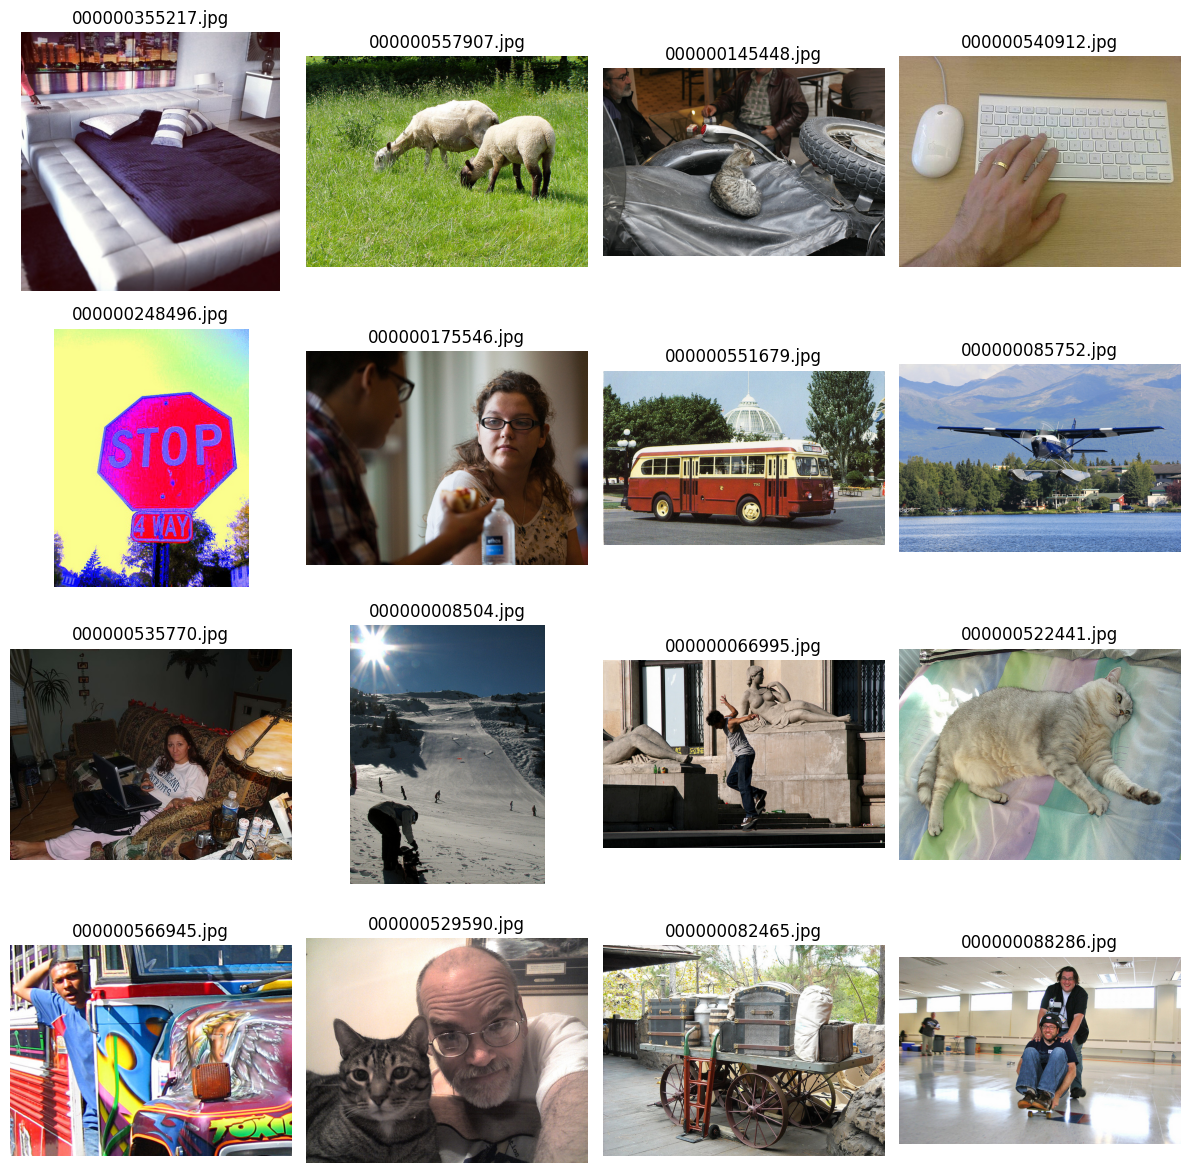

In [7]:
main_folder = r'/kaggle/input/coco-2017-dataset/coco2017/train2017'


all_images = [os.path.join(main_folder, img) for img in os.listdir(main_folder) 
              if img.endswith(('.jpg', '.png', '.webp', '.jpeg'))]

# Randomly select 16 images
random.shuffle(all_images)
selected_images = all_images[:16]

print(f"Found {len(all_images)} images in folder")
print(f"Selected {len(selected_images)} images to display")

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path)[:20])  # Show filename (truncated)

plt.tight_layout()
plt.show()

Found 100000 images in folder
Selected 16 images to display


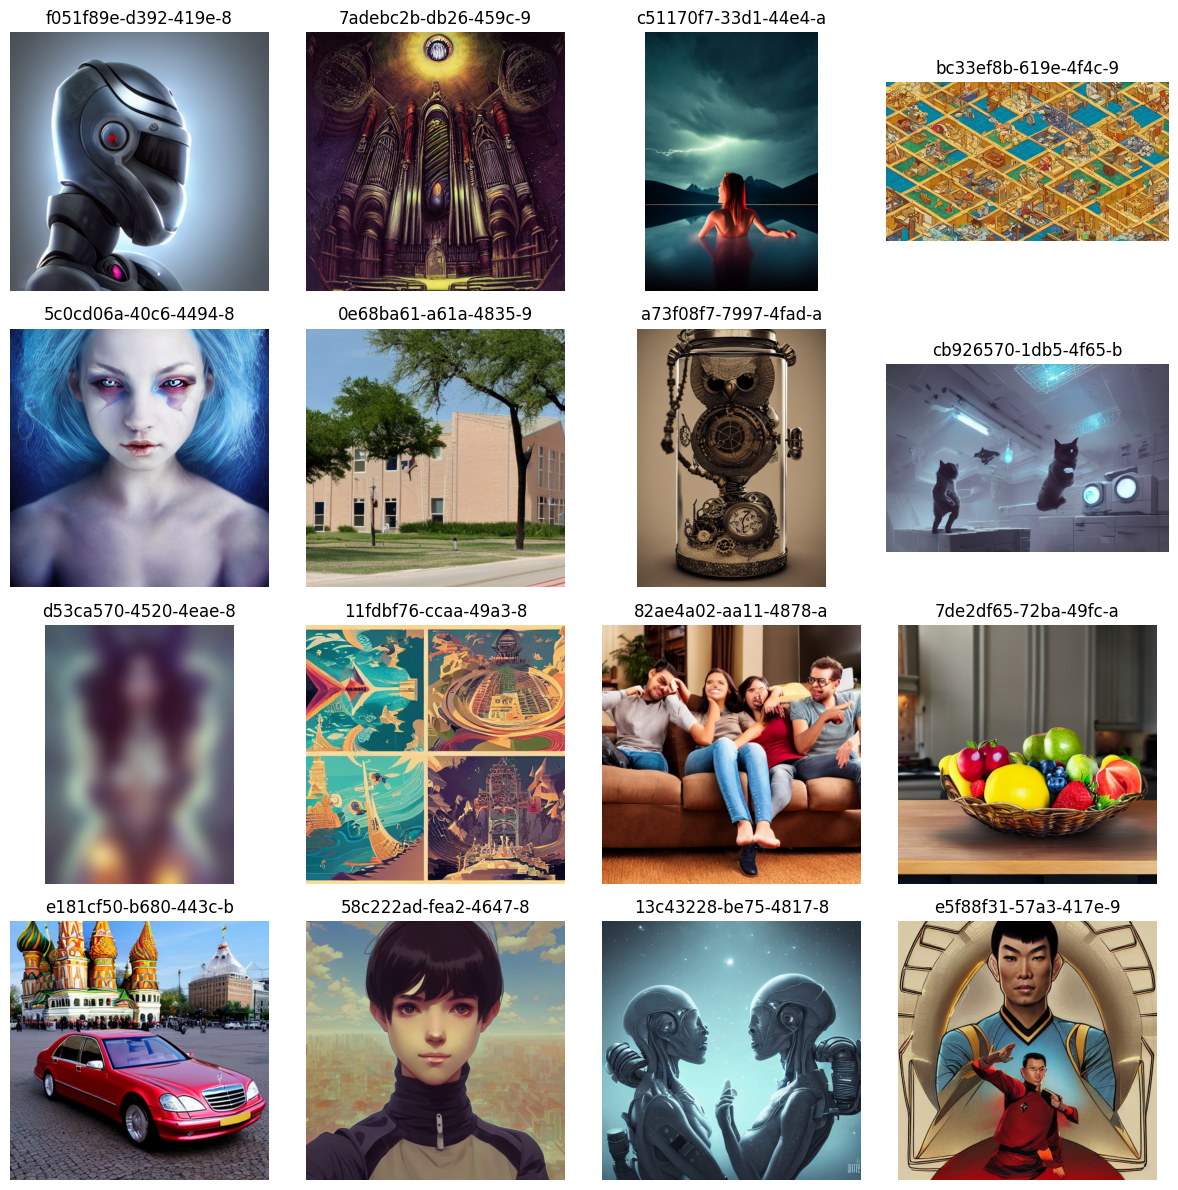

In [8]:
main_folder = r'/kaggle/input/diffusiondb-2m-part-0001-to-0100-of-2000'


all_images = [os.path.join(main_folder, img) for img in os.listdir(main_folder) 
              if img.endswith(('.jpg', '.png', '.webp', '.jpeg'))]

# Randomly select 16 images
random.shuffle(all_images)
selected_images = all_images[:16]

print(f"Found {len(all_images)} images in folder")
print(f"Selected {len(selected_images)} images to display")

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path)[:20])  # Show filename (truncated)

plt.tight_layout()
plt.show()

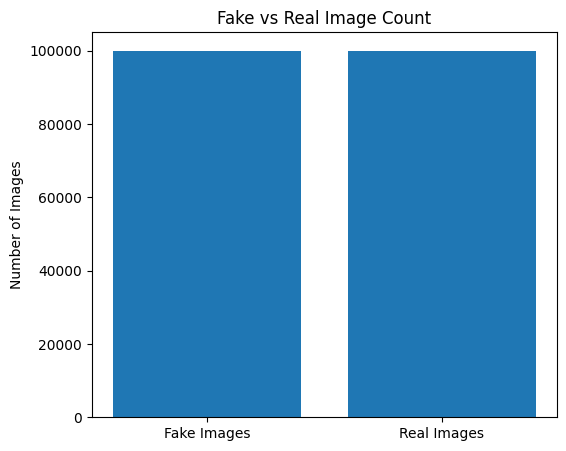

In [9]:
main_folder_fake = r'/kaggle/input/diffusiondb-2m-part-0001-to-0100-of-2000'


all_images_fake = [os.path.join(main_folder, img) for img in os.listdir(main_folder) 
              if img.endswith(('.jpg', '.png', '.webp', '.jpeg'))]
len(all_images_fake)

main_folder_real = r'/kaggle/input/coco-2017-dataset/coco2017/train2017'


all_images_real = [os.path.join(main_folder, img) for img in os.listdir(main_folder) 
              if img.endswith(('.jpg', '.png', '.webp', '.jpeg'))]
len(all_images_real)

counts = [len(all_images_fake), len(all_images_real)]
labels = ['Fake Images', 'Real Images']

plt.figure(figsize=(6, 5))
plt.bar(labels, counts)
plt.ylabel('Number of Images')
plt.title('Fake vs Real Image Count')
plt.show()

In [10]:
len(all_images_fake)

100000

In [11]:
len(all_images_real)

100000

In [12]:
import os
import random
from pathlib import Path

# Configuration
CLASS0_DIR = r"/kaggle/input/diffusiondb-2m-part-0001-to-0100-of-2000"
CLASS1_DIR = r"/kaggle/input/coco-2017-dataset/coco2017/train2017"
OUTPUT_DIR = r"/kaggle/working/"

random.seed(42)

# Get all images
class0_imgs = list(Path(CLASS0_DIR).glob('*.*'))
class1_imgs = list(Path(CLASS1_DIR).glob('*.*'))

random.shuffle(class0_imgs)
random.shuffle(class1_imgs)

# Split indices
splits = {
    'train': (0, 70000),
    'val': (70000, 85000),
    'test': (85000, 100000)
}

# Create symlinks
for split, (start, end) in splits.items():
    for cls, images in [('fake', class0_imgs), ('real', class1_imgs)]:
        out_dir = Path(OUTPUT_DIR) / split / cls
        out_dir.mkdir(parents=True, exist_ok=True)
        
        for img in images[start:end]:
            (out_dir / img.name).symlink_to(img.absolute())
        
        print(f"{split}/{cls}: {end-start} images")

print("Done!")

train/fake: 70000 images
train/real: 70000 images
val/fake: 15000 images
val/real: 15000 images
test/fake: 15000 images
test/real: 15000 images
Done!


In [13]:
train_path = '/kaggle/working/train'
valid_path = '/kaggle/working/val'
test_path = '/kaggle/working/test'

In [14]:
IMAGE_SIZE = 224

BATCH_SIZE = 32

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=True,
    seed=123
)

Found 140000 files belonging to 2 classes.


I0000 00:00:1762730963.222331      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762730963.222969      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [16]:
train_ds.class_names

['fake', 'real']

In [17]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

Found 30000 files belonging to 2 classes.


In [18]:
valid_ds.class_names

['fake', 'real']

In [19]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/working/test',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

Found 30000 files belonging to 2 classes.


In [20]:
test_ds.class_names

['fake', 'real']

In [21]:
normalization = layers.Rescaling(1./255)

def prepare_data(x, y):
    x = normalization(x)
    return x, y

In [22]:
train_ds = train_ds.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [23]:
PATCH_SIZE = 16
EMBED_DIM = 384
NUM_HEADS = 6
NUM_LAYERS = 6
MLP_DIM = 1536
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

In [24]:
def create_vit_model():
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # Patch embedding
    x = layers.Conv2D(
        filters=EMBED_DIM,
        kernel_size=PATCH_SIZE,
        strides=PATCH_SIZE,
        padding='valid',
        name='patch_embedding'
    )(inputs)
    
    # Reshape to sequence: (batch, height, width, channels) -> (batch, num_patches, embed_dim)
    x = layers.Reshape((NUM_PATCHES, EMBED_DIM))(x)
    
    # Create and add class token
    class ClassToken(layers.Layer):
        def __init__(self):
            super().__init__()
        
        def build(self, input_shape):
            self.cls_token = self.add_weight(
                shape=(1, 1, EMBED_DIM),
                initializer='zeros',
                trainable=True,
                name='cls_token'
            )
        
        def call(self, inputs):
            batch_size = tf.shape(inputs)[0]
            cls_token = tf.tile(self.cls_token, [batch_size, 1, 1])
            return tf.concat([cls_token, inputs], axis=1)
    
    x = ClassToken()(x)
    
    # Add position embeddings
    class AddPositionEmbs(layers.Layer):
        def __init__(self, num_patches):
            super().__init__()
            self.num_patches = num_patches
        
        def build(self, input_shape):
            self.pos_emb = self.add_weight(
                shape=(1, self.num_patches + 1, EMBED_DIM),
                initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                trainable=True,
                name='pos_embedding'
            )
        
        def call(self, inputs):
            return inputs + self.pos_emb
    
    x = AddPositionEmbs(NUM_PATCHES)(x)
    
    # Transformer blocks
    for i in range(NUM_LAYERS):
        # Layer normalization 1
        x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Multi-head attention
        attn_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS,
            key_dim=EMBED_DIM,
            dropout=0.1
        )(x_norm, x_norm)
        
        # Skip connection 1
        x = layers.Add()([x, attn_output])
        
        # Layer normalization 2
        x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # MLP
        mlp = keras.Sequential([
            layers.Dense(MLP_DIM, activation='gelu'),
            layers.Dropout(0.1),
            layers.Dense(EMBED_DIM),
            layers.Dropout(0.1)
        ])
        mlp_output = mlp(x_norm)
        
        # Skip connection 2
        x = layers.Add()([x, mlp_output])
    
    # Final layer normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Extract CLS token (first token)
    x = layers.Lambda(lambda v: v[:, 0])(x)
    
    # Classification head
    x = layers.Dense(512, activation='gelu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name='vision_transformer')

# Create model
vit_model = create_vit_model()

print("\n" + "="*60)
print("Vision Transformer Model Built Successfully!")
print("="*60)
vit_model.summary()


Vision Transformer Model Built Successfully!


Model: "vision_transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 14, 14,    │    295,296 │ input_layer[0][0] │
│ (Conv2D)            │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 196, 384)  │          0 │ patch_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_token         │ (None, 197, 384)  │        384 │ reshape[0][0]     │
│ (ClassToken)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_position_embs   │ (None, 197, 384)  │     75,648 │ class_token[0][0] │
│ (AddPositionEmbs)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 197, 384)  │        768 │ add_position_emb… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 197, 384)  │  3,546,240 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 197, 384)  │          0 │ add_position_emb… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 197, 384)  │        768 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 197, 384)  │  1,181,568 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 197, 384)  │          0 │ add[0][0],        │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 197, 384)  │        768 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 197, 384)  │  3,546,240 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 197, 384)  │          0 │ add_1[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 197, 384)  │        768 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 197, 384)  │  1,181,568 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 197, 384)  │          0 │ add_2[0][0],      │
│                     │                   │            │ sequential_1[0][

 Total params: 28,945,793 (110.42 MB)

 Trainable params: 28,945,793 (110.42 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# # Patch embedding using Conv2D
# patch_projection = layers.Conv2D(EMBED_DIM, kernel_size=PATCH_SIZE, strides=PATCH_SIZE)(inputs)
# patch_shape = tf.shape(patch_projection)
# patches = tf.reshape(patch_projection, [-1, patch_shape[1] * patch_shape[2], patch_shape[3]])

# print(f"Patch embedding created with {EMBED_DIM} dimensions")

In [26]:
# num_patches = (IMAGE_SIZE // PATCH_SIZE) ** 2

# # Add class token
# class_token = tf.Variable(tf.zeros([1, 1, EMBED_DIM]), trainable=True, name='class_token')
# class_tokens = tf.tile(class_token, [tf.shape(patches)[0], 1, 1])
# patches_with_class = tf.concat([class_tokens, patches], axis=1)

# # Add position embeddings
# pos_embed = tf.Variable(tf.random.normal([1, num_patches + 1, EMBED_DIM], stddev=0.02), 
#                         trainable=True, name='pos_embed')
# encoded_patches = patches_with_class + pos_embed

# print(f"Position encoding added for {num_patches} patches + 1 class token")


In [27]:
# x = encoded_patches

# for i in range(NUM_LAYERS):
#     # Layer Normalization 1
#     x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
    
#     # Multi-Head Attention
#     att_output = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)(x_norm, x_norm)
#     x = x + att_output
    
#     # Layer Normalization 2
#     x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
    
#     # MLP
#     mlp_output = layers.Dense(MLP_DIM, activation='gelu')(x_norm)
#     mlp_output = layers.Dropout(0.1)(mlp_output)
#     mlp_output = layers.Dense(EMBED_DIM)(mlp_output)
#     mlp_output = layers.Dropout(0.1)(mlp_output)
    
#     x = x + mlp_output
    
#     print(f"Transformer block {i+1}/{NUM_LAYERS} added")

In [28]:
# x = layers.LayerNormalization(epsilon=1e-6)(x)
# x = x[:, 0]  # Extract class token
# x = layers.Dense(512, activation='gelu')(x)
# x = layers.Dropout(0.3)(x)
# outputs = layers.Dense(1, activation='sigmoid')(x)

# vit_model = keras.Model(inputs, outputs, name='vision_transformer')

# print("\n" + "="*60)
# print("Vision Transformer Model Built Successfully!")
# print("="*60)
# vit_model.summary()

In [29]:
vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy', 
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("Model compiled successfully!")

Model compiled successfully!


In [30]:
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True, 
        verbose=1
    ),
    ModelCheckpoint(
        'vit_best_model.keras', 
        monitor='val_loss', 
        save_best_only=True, 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-7, 
        verbose=1
    )
]

print("Callbacks configured!")

Callbacks configured!


In [31]:
history = vit_model.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds,
    callbacks=callbacks
)

Epoch 1/20


I0000 00:00:1762731078.693172      76 service.cc:148] XLA service 0x7941a0003090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762731078.693752      76 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762731078.693773      76 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762731081.522437      76 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762731099.676081      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.7049 - auc: 0.7807 - loss: 0.5395 - precision: 0.7013 - recall: 0.7129
Epoch 1: val_loss improved from inf to 0.34225, saving model to vit_best_model.keras
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 2613s 589ms/step - accuracy: 0.7049 - auc: 0.7807 - loss: 0.5395 - precision: 0.7014 - recall: 0.7129 - val_accuracy: 0.8605 - val_auc: 0.9347 - val_loss: 0.3423 - val_precision: 0.8686 - val_recall: 0.8494 - learning_rate: 1.0000e-04
Epoch 2/20
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8608 - auc: 0.9334 - loss: 0.3289 - precision: 0.8554 - recall: 0.8683
Epoch 2: val_loss improved from 0.34225 to 0.31488, saving model to vit_best_model.keras
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 2566s 587ms/step - accuracy: 0.8608 - auc: 0.9334 - loss: 0.3289 - precision: 0.8554 - recall: 0.8683 - val_accuracy: 0.8677 - val_auc: 0.9512 - val_loss: 0.3149 - val_precision: 0.9226 - val_recall: 0.8028 - learning_rate: 1.0000e-04
Epoch 3/20
4375/4375 ━━

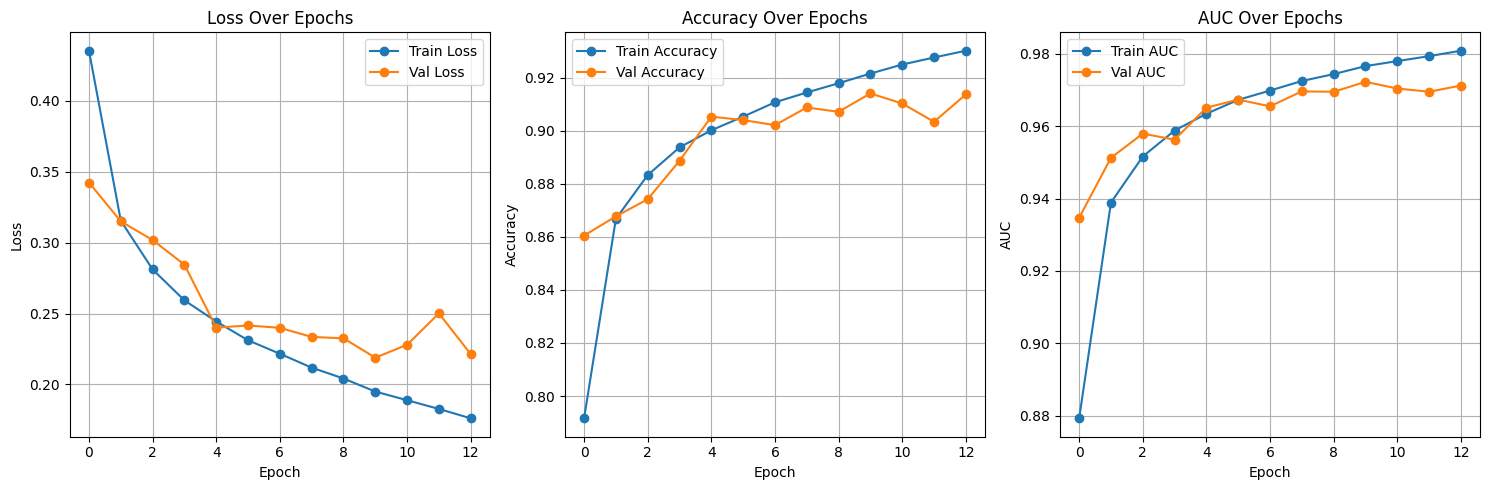

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC', marker='o')
plt.plot(history.history['val_auc'], label='Val AUC', marker='o')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [33]:
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

results = vit_model.evaluate(test_ds, batch_size=BATCH_SIZE)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test Precision: {results[2]:.4f}")
print(f"Test Recall: {results[3]:.4f}")
print(f"Test AUC: {results[4]:.4f}")



EVALUATING ON TEST SET
938/938 ━━━━━━━━━━━━━━━━━━━━ 184s 196ms/step - accuracy: 0.9193 - auc: 0.4879 - loss: 0.1964 - precision: 0.3922 - recall: 0.4529

Test Loss: 0.2198
Test Accuracy: 0.9114
Test Precision: 0.9204
Test Recall: 0.9007
Test AUC: 0.9720


In [34]:
predictions = vit_model.predict(test_ds)
y_pred = (predictions > 0.5).astype(int).flatten()

y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true).astype(int)

min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

print(f"Predictions generated for {min_len} samples")

938/938 ━━━━━━━━━━━━━━━━━━━━ 163s 171ms/step
Predictions generated for 30000 samples


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     15000
           1       0.92      0.90      0.91     15000

    accuracy                           0.91     30000
   macro avg       0.91      0.91      0.91     30000
weighted avg       0.91      0.91      0.91     30000



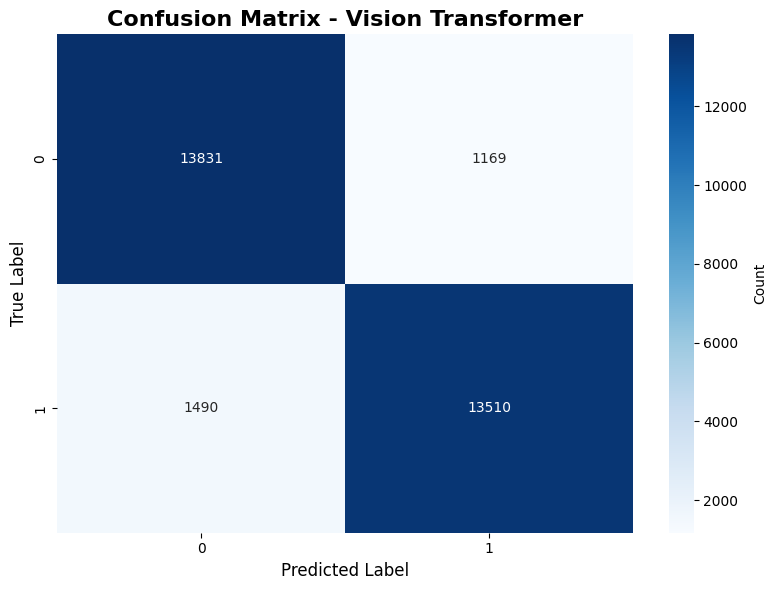

In [36]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Vision Transformer', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [37]:
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*60)
print("CONFUSION MATRIX BREAKDOWN")
print("="*60)
print(f"True Negatives:  {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives:  {tp:,}")
print(f"\nSpecificity: {tn/(tn+fp):.4f}")
print(f"Sensitivity (Recall): {tp/(tp+fn):.4f}")
print(f"F1-Score: {2*tp/(2*tp+fp+fn):.4f}")
print(f"Accuracy: {(tp+tn)/(tp+tn+fp+fn):.4f}")


CONFUSION MATRIX BREAKDOWN
True Negatives:  13,831
False Positives: 1,169
False Negatives: 1,490
True Positives:  13,510

Specificity: 0.9221
Sensitivity (Recall): 0.9007
F1-Score: 0.9104
Accuracy: 0.9114
